### Import Necessary Libraries

In [1]:
import os
import re
import umap
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from astropy.io import fits
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.transforms import v2
from torchcam.methods import GradCAMpp
from ipywidgets import interact, IntSlider
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Gathering FITS Dataset

In [2]:
dataset = "../continuum_data_subset" # Edit the dataset path
listDir = os.listdir(dataset)

listDir = sorted(listDir, key=lambda x: int(re.search(r'planet(\d+)_', x).group(1))) # Sort in ascending order of planet numbers

imgList, planetNum = [], []

for i in range(len(listDir)):
    hdu = fits.open(os.path.join(dataset, listDir[i]))
    img = hdu[0].data[0].squeeze()
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)
    imgList.append(img)
    planetNum.append(int(re.search(r'planet(\d+)_', listDir[i]).group(1)))

imgList = np.array(imgList)
planetNum = np.array(planetNum)

### Plot for Visual Inspection (Remove first line to view the planets)

In [3]:
%%script echo skipping
def plot(mul):
    num = 15
    fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))

    for i in range(num*mul, num*(mul+1)):
        i -= num * mul
        ax[i//5, i%5].imshow(imgList[i+num*mul], cmap="gray")
        ax[i//5, i%5].set_title(f"Planet: {planetNum[i+num*mul]}")
    fig.tight_layout()

for i in range(10):
    plot(i)
plt.show()

print(f"Unique planets by number: {np.unique(planetNum).shape[0]}")

skipping


In [4]:
print(f"Unique planets by number: {np.unique(planetNum).shape[0]}") # Number of Unique planets in the dataset

Unique planets by number: 73


### ConvNext Large Feature Extraction

One of the best state-of-the-art convolutional model for feature extraction according to [An evaluation of pre-trained models for feature extraction in image classification](https://arxiv.org/abs/2310.02037)

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.convnext_large(weights="ConvNeXt_Large_Weights.IMAGENET1K_V1")
model.features[0][0] = nn.Conv2d(in_channels=1, out_channels=192, kernel_size=(4, 4), stride=(4, 4)) # edit the model to take grayscale images
model = model.to(device)

### Image Transform and Preprocessing

In [31]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

imgTensor = []
for img in imgList:
    img_pil = Image.fromarray(img.astype('float32')).convert('L')
    transformImg = transform(img_pil)
    imgTensor.append(transformImg)

imgTensor = torch.tensor(np.array(imgTensor), dtype=torch.float32)

### Gathering Planet Features (Forward pass through the model)

In [32]:
featureTensors = []
model.eval()
with torch.no_grad():
    for i in range(0, imgTensor.shape[0]):
        batchImg = imgTensor[i].unsqueeze(0).to(device)
        features = model(batchImg)
        featureTensors.append(features.squeeze().cpu().numpy().flatten())

featureTensors = np.array(featureTensors) # Each features of 1000 dimension

### Visualizing Activation Maps

Visualizing the feature maps from the conv layers in ConvNext model for 3 images. This cell is expected to run for more than a minute

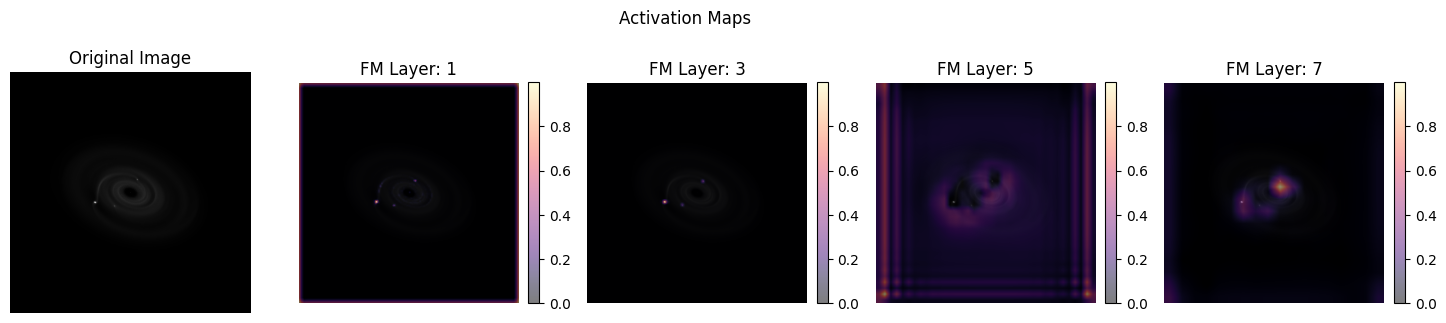

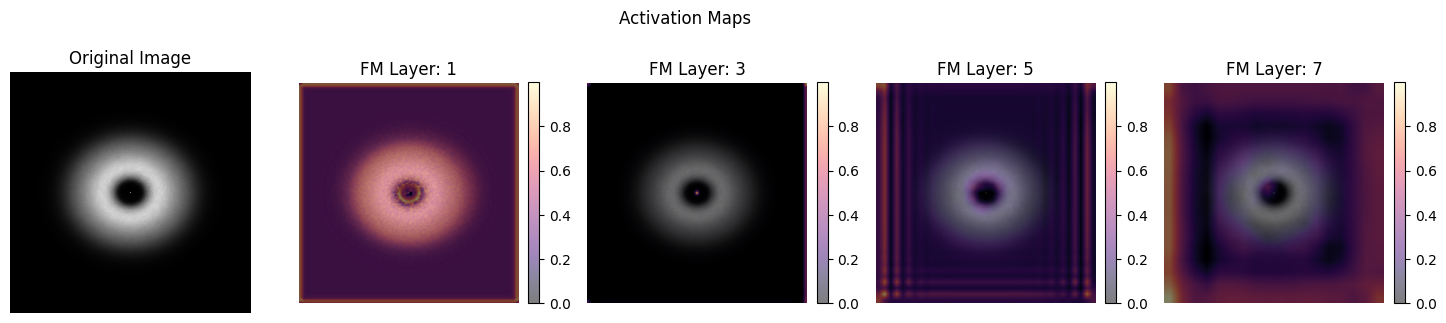

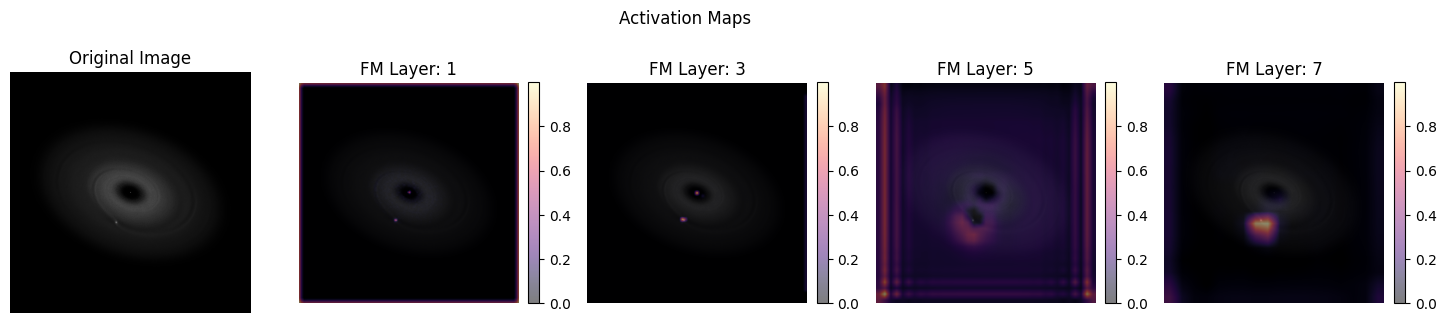

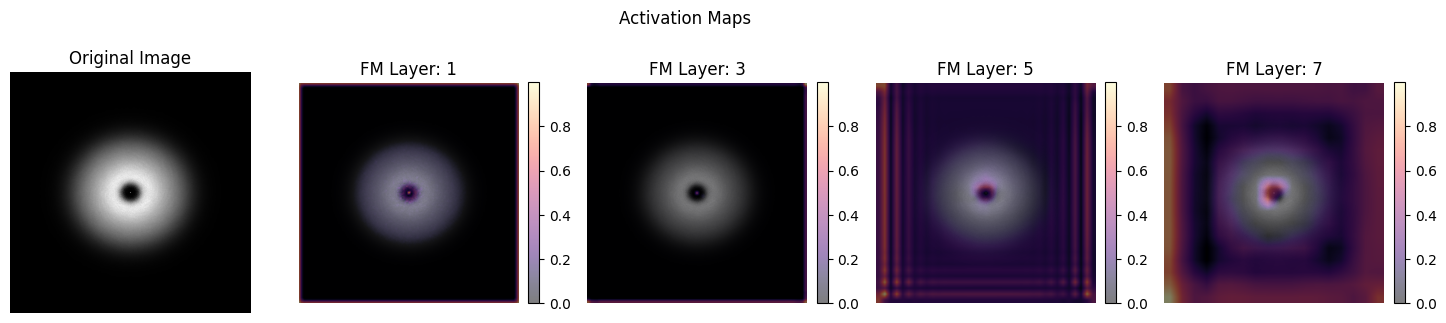

In [33]:
model.eval()
run_device = "cpu"
planetrandom = [0, 35, 70, 120]

for i in planetrandom:
    img = imgTensor[i].unsqueeze(0).to(run_device)

    # target conv layers from ConvNext
    target_layer = [
        model.features[1],
        model.features[3],
        model.features[5],
        model.features[7],
    ]

    activation_maps = []
    for i, layer in enumerate(target_layer, start=1):
        cam_extractor = GradCAMpp(model, layer)

        model.to(run_device)
        output = model(img)
        activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)

        # Resizing activation map to input image size
        activation = F.interpolate(
            activation_map[0].unsqueeze(0), 
            size=img.squeeze(0,1).shape, 
            mode='bilinear', 
            align_corners=False
        ).squeeze().cpu().numpy()
        
        activation = (activation - activation.min()) / (activation.max() - activation.min() + 1e-7)
        activation_maps.append(activation)

    imgNp = img.squeeze(0,1).cpu().numpy()

    _, ax = plt.subplots(nrows=1, ncols=5, figsize=(18, 6))

    ax[0].imshow(imgNp, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    for i in range(len(target_layer)):
        ax[i+1].imshow(imgNp, cmap='gray')
        ax[i+1].set_title(f"FM Layer: {2*i+1}")
        heatmap = ax[i+1].imshow(activation_maps[i], cmap='magma', alpha=0.5)
        cbar = plt.colorbar(heatmap, fraction=0.046, pad=0.04)
        ax[i+1].axis('off')

    plt.suptitle("Activation Maps", y=0.8)
    plt.show()

### Umap + Gaussian Misxture Model for Clustering

Determining the optimal number of clusters using Silhouette Score and Davies-Bouldin Score, where a higher Silhouette Score and a lower DB Score indicate a better choice. UMAP was applied to extract the top three components from the 1000 features for GMM clustering. Given the variability of this approach, image inspection was conducted alongside these metrics to validate the cluster count.

/home/gokul/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster 6 with highest silhouette score : 0.5027718544006348
Cluster 6 with lowest Davies-Bouldin index: 0.7185429545676727


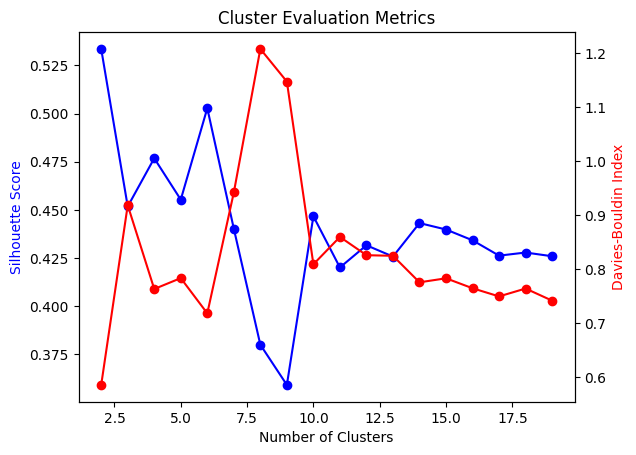

In [45]:
reducer = umap.UMAP(n_components=3, n_neighbors=50, metric="manhattan") # UMAP to select components
embedding = reducer.fit_transform(featureTensors)

sil_scores = []
db_scores = []
cluster_range = range(2, 20)

for k in cluster_range: # loop over various cluster numbers
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42) # GMM
    labels = gmm.fit_predict(embedding)
    
    sil_scores.append(silhouette_score(embedding, labels))
    db_scores.append(davies_bouldin_score(embedding, labels))

fig, ax1 = plt.subplots()

ax1.plot(cluster_range, sil_scores, 'bo-', label='Silhouette Score')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score', color='b')

ax2 = ax1.twinx()
ax2.plot(cluster_range, db_scores, 'ro-', label='Davies-Bouldin Index')
ax2.set_ylabel('Davies-Bouldin Index', color='r')

print(f"Cluster {np.argmax(sil_scores[1:], )+3} with highest silhouette score : {np.max(sil_scores[1:])}")
print(f"Cluster {np.argmin(db_scores[1:], )+3} with lowest Davies-Bouldin index: {np.min(db_scores[1:])}")

plt.title("Cluster Evaluation Metrics")
plt.show()

### GMM with 6 clusters

In [46]:
num_clusters = 6
gmm = GaussianMixture(n_components=num_clusters, covariance_type="full", random_state=42)
labels = gmm.fit_predict(embedding)

### Interactive Cluster Plot (Use Cursor to view all clusters)

In [47]:
def plot_cluster(imgList, labels, n_clusters, images_per_row=10):
    @interact(cluster=IntSlider(min=0, max=n_clusters-1, step=1, description="Cluster:", continuous_update=False))
    def show_cluster(cluster=0):
        cluster_idx = np.where(labels == cluster)[0]
        num_images = len(cluster_idx)

        if num_images == 0:
            print(f"Cluster {cluster+1} is empty")
            return

        rows = int(np.ceil(num_images / images_per_row))
        figsize_width = min(images_per_row * 2, 20)
        figsize_height = rows * 2

        _, axs = plt.subplots(rows, images_per_row, figsize=(figsize_width, figsize_height), squeeze=False)
        for i, idx in enumerate(cluster_idx):
            row = i // images_per_row
            col = i % images_per_row
            axs[row, col].imshow(imgList[idx].squeeze().numpy(), cmap='gray')
            axs[row, col].axis('off')
        
        for i in range(num_images, rows*images_per_row):
            row = i // images_per_row
            col = i % images_per_row
            axs[row, col].axis('off')
        
        plt.suptitle(f"Cluster {cluster+1} ({num_images} images)", y=0.99)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

plot_cluster(imgTensor, labels, num_clusters, images_per_row=10)


interactive(children=(IntSlider(value=0, continuous_update=False, description='Cluster:', max=5), Output()), _…